# Define model, layers and activation function for NN

In [82]:
import numpy as np



# Dense layer
class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons,
                 weight_regularizer_l1=0, weight_regularizer_l2=0,
                 bias_regularizer_l1=0, bias_regularizer_l2=0):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        # Set regularization strength
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases
    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # Gradients on regularization
        # L1 on weights
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        # L2 on weights
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * \
                             self.weights
        # L1 on biases
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1
        # L2 on biases
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * \
                            self.biases

        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)


# ReLU activation
class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

# Softmax activation
class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

    # Backward pass
    def backward(self, dvalues):

        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
                enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix,
                                         single_dvalues)


# SGD optimizer
class Optimizer_SGD:

    # Initialize optimizer - set settings,
    # learning rate of 1. is default for this optimizer
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If we use momentum
        if self.momentum:

            # If layer does not contain momentum arrays, create them
            # filled with zeros
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                # If there is no momentum array for weights
                # The array doesn't exist for biases yet either.
                layer.bias_momentums = np.zeros_like(layer.biases)

            # Build weight updates with momentum - take previous
            # updates multiplied by retain factor and update with
            # current gradients
            weight_updates = \
                self.momentum * layer.weight_momentums - \
                self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            # Build bias updates
            bias_updates = \
                self.momentum * layer.bias_momentums - \
                self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates

        # Vanilla SGD updates (as before momentum update)
        else:
            weight_updates = -self.current_learning_rate * \
                             layer.dweights
            bias_updates = -self.current_learning_rate * \
                           layer.dbiases

        # Update weights and biases using either
        # vanilla or momentum updates
        layer.weights += weight_updates
        layer.biases += bias_updates

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1
# Adagrad optimizer
class Optimizer_Adagrad:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=1., decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



# RMSprop optimizer
class Optimizer_RMSprop:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update cache with squared current gradients
        layer.weight_cache = self.rho * layer.weight_cache + \
            (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + \
            (1 - self.rho) * layer.dbiases**2

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         layer.dweights / \
                         (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * \
                        layer.dbiases / \
                        (np.sqrt(layer.bias_cache) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1



# Adam optimizer
class Optimizer_Adam:

    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,
                 beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * \
                (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):

        # If layer does not contain cache arrays,
        # create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum  with current gradients
        layer.weight_momentums = self.beta_1 * \
                                 layer.weight_momentums + \
                                 (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * \
                               layer.bias_momentums + \
                               (1 - self.beta_1) * layer.dbiases
        # Get corrected momentum
        # self.iteration is 0 at first pass
        # and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / \
            (1 - self.beta_1 ** (self.iterations + 1))
        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + \
            (1 - self.beta_2) * layer.dweights**2

        layer.bias_cache = self.beta_2 * layer.bias_cache + \
            (1 - self.beta_2) * layer.dbiases**2
        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / \
            (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization
        # with square rooted cache
        layer.weights += -self.current_learning_rate * \
                         weight_momentums_corrected / \
                         (np.sqrt(weight_cache_corrected) +
                             self.epsilon)
        layer.biases += -self.current_learning_rate * \
                         bias_momentums_corrected / \
                         (np.sqrt(bias_cache_corrected) +
                             self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1


# Common loss class
class Loss:

    # Regularization loss calculation
    def regularization_loss(self, layer):

        # 0 by default
        regularization_loss = 0

        # L1 regularization - weights
        # calculate only when factor greater than 0
        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * \
                                   np.sum(np.abs(layer.weights))

        # L2 regularization - weights
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * \
                                   np.sum(layer.weights *
                                          layer.weights)


        # L1 regularization - biases
        # calculate only when factor greater than 0
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * \
                                   np.sum(np.abs(layer.biases))

        # L2 regularization - biases
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * \
                                   np.sum(layer.biases *
                                          layer.biases)

        return regularization_loss

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss


# Cross-entropy loss
class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():

    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)


    # Backward pass
    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)

        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples



# Get Data and preprocessing

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
dataDir = "/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/"
dataFiles=['female_1.mat','female_2.mat','female_3.mat','male_1.mat','male_2.mat']
dataFiles=['female_1.mat']

data = [] #processed and normalised with pose_idx
e = 2.718281828459045

def normalize_arr(arr,i):
    signal = arr.copy()
    signal -= np.amax(arr)
    signal = e**signal
    signal /= np.sum(signal)
    signal = np.clip(signal,1e-7,1e+7)
    signal = signal.tolist()
    signal.append(int(i/2))
    return signal

def get_channel_pair(chn1,chn2,i):
    paired_data = []
    label = list((np.array(chn1).T)[-1].T.astype(int))

    chn1 =  list(np.delete(chn1,0,1))
    chn2 =  list(np.delete(chn2,0,1))
    # print(np.array(chn1).shape)
    print(label)
    # print('label[i]: ',label[i])
    for chunk1 in chn1:
        chunk2 = chn2[i].T
        chunk1 = chunk1.T

        while(len(chunk1)>0):
            row=[chunk1[0],chunk2[0],label[5]]
            paired_data.append(row)

            chunk1 = list(chunk1)
            chunk2 = list(chunk2)
            chunk1.pop(0)
            chunk2.pop(0)

    return paired_data




for file in dataFiles:
    data_path = dataDir+file
    print(data_path)
    mat = scipy.io.loadmat(data_path)
    mat.pop("__header__")
    mat.pop("__version__")
    mat.pop("__globals__")
    i=0
    for channel in mat: 
        if(i%2==0):
            channel2 =  channel[:-1]
            channel2 += '2'
            sigs1 = mat[channel] 
            sigs2 = mat[channel2]
            sigs1_norm = []
            sigs2_norm = []

            for signal in sigs1:
                signal = normalize_arr(signal,i)
                sigs1_norm.append(signal)
            for signal in sigs2:
                signal = normalize_arr(signal,i)
                sigs2_norm.append(signal)

            if i==0:
                data = get_channel_pair(sigs1_norm,sigs2_norm,i)
                # print(data)
            else:
                None
                data_lc = get_channel_pair(sigs1_norm,sigs2_norm,i)
                data += data_lc
                # data = data_lc
        i+=1
print(np.array(data).shape)
print(data[-3])






/media/james/Datasets_Drive/semg_for_basic_hand_movement/Database_1/female_1.mat
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
(540000, 3)
[0.0002986961254352518, 0.0002797453486948402, 5]


In [84]:
import pandas as pd
dataset = data.copy()
df = pd.DataFrame(dataset, columns = ['channel1','channel2','label'])

print(df)
mask = np.random.rand(len(df)) < 0.8
dataset_train = df[mask]
dataset_test = df[~mask]

X = dataset_train[["channel1","channel2"]].to_numpy()
y = dataset_train["label"].to_numpy()

X_test = dataset_test[["channel1","channel2"]].to_numpy()
y_test =  dataset_test["label"].to_numpy()
print('train labels: ',dataset_train['label'].unique())
print('test labels: ',dataset_test['label'].unique())

        channel1  channel2  label
0       0.000271  0.000368      0
1       0.000316  0.000308      0
2       0.000286  0.000308      0
3       0.000233  0.000324      0
4       0.000227  0.000308      0
...          ...       ...    ...
539995  0.000284  0.000310      5
539996  0.000299  0.000334      5
539997  0.000299  0.000280      5
539998  0.000348  0.000352      5
539999  5.000000  5.000000      5

[540000 rows x 3 columns]
train labels:  [0 1 2 3 4 5]
test labels:  [0 1 2 3 4 5]


In [85]:
import pandas as pd

def reshape_sample_X(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    newShape_label = []
    time = 0
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        if(len(reshape_data)==n*2):
            newShape_data.append(reshape_data)
            newShape_label.append(label[i])
        i += n
        if(i>=chn1.size):
            # print(reshape_data)  
            print(label[i-20])
        time += 1
    print(i)
    newShape_data = np.array(newShape_data)

    return newShape_data
def reshape_sample_y(n,df_data):
    # get n channel 1 and n channel 2 into 1 sample
    chn1 = df_data['channel1'].to_numpy()
    chn2 = df_data['channel2'].to_numpy()
    label = df_data['label'].to_numpy()
    i = 0
    newShape_data = []
    newShape_label = []
    time = 0
    while i < chn1.size:
        #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
        reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
        if(len(reshape_data)==n*2):
            newShape_data.append(reshape_data)
            newShape_label.append(label[i])
        i += n
        if(i>=chn1.size):
            # print(reshape_data)  
            print(label[i-20])
        time += 1
    newShape_label = np.array(newShape_label)
    return newShape_label

# print(df)
df = pd.DataFrame(dataset, columns = ['channel1','channel2','label'])
mask = np.random.rand(len(df)) < 0.8
dataset_train = df[mask]
dataset_test = df[~mask]

n=20
X =  reshape_sample_X(n,dataset_train)
y =  reshape_sample_y(n,dataset_train)

X_test =reshape_sample_X(n,dataset_test)
y_test =  reshape_sample_y(n,dataset_test)

# X = batchTrain[0]
# y = batchTrain[1]

# X = reshape_sample(20,df)


# X = dataset_train[["channel1","channel2"]].to_numpy()
# y = dataset_train["label"].to_numpy()

# X_test = dataset_test[["channel1","channel2"]].to_numpy()
# y_test =  dataset_test["label"].to_numpy()
# print('train labels: ',dataset_train['label'].unique())
# print('test labels: ',dataset_test['label'].unique())

5
431580
5
5
108440
5


In [86]:
X

array([[0.00027135, 0.00031622, 0.00028555, ..., 0.0003322 , 0.00031568,
        0.00029998],
       [0.00018988, 0.00022127, 0.00023887, ..., 0.00035862, 0.00031568,
        0.0003322 ],
       [0.00029293, 0.00023887, 0.00018044, ..., 0.00031568, 0.00029242,
        0.0003322 ],
       ...,
       [0.00029118, 0.00037576, 0.00034808, ..., 0.0003178 , 0.00033443,
        0.00039981],
       [0.00034808, 0.00041611, 0.00044919, ..., 0.00033443, 0.00028697,
        0.00033443],
       [0.00024986, 0.00023744, 0.00029118, ..., 0.00030979, 0.00037992,
        0.00038974]])

In [87]:
# import pandas as pd

# def reshape_sample(n,df_data):
#     # get n channel 1 and n channel 2 into 1 sample
#     chn1 = df_data['channel1'].to_numpy()
#     chn2 = df_data['channel2'].to_numpy()
#     label = df_data['label'].to_numpy()
#     i = 0
#     newShape_data = []
#     newShape_label = []
#     time = 0
#     while i < chn1.size:
#         #currently  the size is 540000, tack batch 20 signals, the loop will rn 27000 times
#         reshape_data = np.concatenate((chn1[i:i+n], chn2[i:i+n]))
#         if(len(reshape_data)==n*2):
#             newShape_data.append(reshape_data)
#             newShape_label.append(label[i])
#         i += n
#         if(i>=chn1.size):
#             # print(reshape_data)  
#             print(label[i-20])
#         time += 1
#     print(i)
#     print(newShape_label)
#     print(len(newShape_label))
#     print(newShape_data)
#     print(len(newShape_data))
#     print(time)
#     newShape_data = np.array(newShape_data)
#     newShape_label = np.array(newShape_label)
#     res_batch = np.array([newShape_data,newShape_label])
#     res_batch = newShape_data
#     res_batch = newShape_label


#     print(newShape_data.size)
#     print(len(newShape_data))
#     # return newShape_data
#     return res_batch

# # print(df)
# df = pd.DataFrame(dataset, columns = ['channel1','channel2','label'])
# mask = np.random.rand(len(df)) < 0.8
# dataset_train = df[mask]
# dataset_test = df[~mask]

# n=20
# batchTrain =  reshape_sample(n,dataset_train)


In [93]:
og_X = np.array(X.copy())
print(type(og_X))
while(og_X.size!=0):
    print('iterate')
    og_X =np.array( [])


<class 'numpy.ndarray'>
iterate


In [96]:
acc_draw = []
loss_draw = []
data_loss_draw= []
reg_loss_draw = []
learn_rate_draw = []

In [98]:
# Create Dense layer with 2 input features and 64 output values
# n=2
dense1 = Layer_Dense(n*2, 64, weight_regularizer_l2=5e-4,
                            bias_regularizer_l2=5e-4)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
dense2 = Layer_Dense(64, 30, weight_regularizer_l2=5e-4,
                            bias_regularizer_l2=5e-4)
# Create ReLU activation (to be used with Dense layer):
activation2 = Activation_ReLU()


dense3 = Layer_Dense(30, 15, weight_regularizer_l2=5e-4,
                            bias_regularizer_l2=5e-4)
# Create ReLU activation (to be used with Dense layer):
activation3 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense0 = Layer_Dense(15, 6)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer
optimizer = Optimizer_Adam(learning_rate=0.02, decay=5e-7)

# Train in loop
for epoch in range(10001):

    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    dense2.forward(dense1.output)
    dense3.forward(dense2.output)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    activation2.forward(dense2.output)
    activation3.forward(dense3.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense0.forward(activation3.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    data_loss = loss_activation.forward(dense0.output, y)

    # Calculate regularization penalty
    regularization_loss = \
        loss_activation.loss.regularization_loss(dense1) + \
        loss_activation.loss.regularization_loss(dense2)

    # Calculate overall loss
    loss = data_loss + regularization_loss

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {regularization_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')
        acc_draw.append(accuracy)
        loss_draw.append(loss)
        data_loss_draw.append(data_loss)
        reg_loss_draw.append(regularization_loss)
        learn_rate_draw.append(optimizer.current_learning_rate)

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense0.backward(loss_activation.dinputs)
    
    activation3.backward(dense0.dinputs)
    dense3.backward(activation3.dinputs)

    activation2.backward(dense3.dinputs)
    dense2.backward(activation2.dinputs)

    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.update_params(dense3)
    optimizer.update_params(dense0)
    optimizer.post_update_params()





epoch: 0, acc: 0.183, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.02
epoch: 100, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.019999010049002574
epoch: 200, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.019998010197985302
epoch: 300, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.019997010446938183
epoch: 400, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.01999601079584623
epoch: 500, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.01999501124469445
epoch: 600, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.01999401179346786
epoch: 700, acc: 0.167, loss: 1.792 (data_loss: 1.792, reg_loss: 0.000), lr: 0.01999301244215147


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
acc_draw.pop(0)
loss_draw.pop(0)
data_loss_draw.pop(0)
reg_loss_draw.pop(0)
learn_rate_draw.pop(0)

1e-05

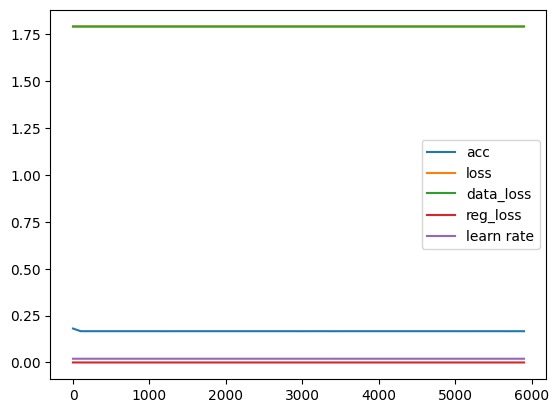

In [ ]:

step = 100
plt.plot(range(0,epoch,step),acc_draw, label='acc')
plt.plot(range(0,epoch,step),loss_draw, label='loss')
plt.plot(range(0,epoch,step),data_loss_draw, label='data_loss')
plt.plot(range(0,epoch,step),reg_loss_draw, label='reg_loss')
plt.plot(range(0,epoch,step),learn_rate_draw, label='learn rate')
plt.legend()
plt.show()

In [ ]:
# Validate the model

# Perform a forward pass of our testing data through this layer
dense1.forward(X_test)
dense2.forward(dense1.output)
dense3.forward(dense2.output)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
activation2.forward(dense2.output)
activation3.forward(dense3.output)

# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense0.forward(activation3.output)

# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense0.output, y_test)

# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions==y_test)

print(f'validation, acc: {accuracy:.3f}, loss: {loss:.3f}')


# epoch: 10000, acc: 0.947, loss: 0.217 (data_loss: 0.157, reg_loss: 0.060), lr: 0.019900507413187767
# validation, acc: 0.830, loss: 0.435

validation, acc: 0.166, loss: 1.792


In [ ]:
import bluetooth

nearby_devices = bluetooth.discover_devices(lookup_names=True)
print("Found {} devices.".format(len(nearby_devices)))

for addr, name in nearby_devices:
    print("  {} - {}".format(addr, name))

In [ ]:
predictions

array([5, 5, 5, ..., 5, 5, 5])